# Setup

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import copy
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import tqdm

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print('Runtime is not GPU accelerated')

Tesla T4


# Loading Dataset

In [0]:
transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

transforms_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_test)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
num_classes = 10
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [7]:
dataiter =  iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
1


In [0]:
def imshow(img, title):
    npimg = img.numpy() *0.5 + 0.5
    npimg = np.transpose(npimg, (1,2,0))
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(npimg)
    plt.title(title)
    plt.show()

In [0]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    title = [str(x.item()) for x in labels]
    imshow(img, title)

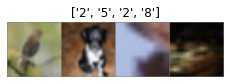

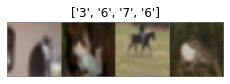

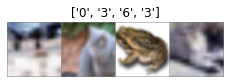

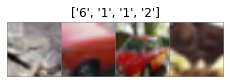

In [10]:
for i in range(batch_size):
    show_batch_images(trainloader)

# VGG16

In [0]:
from torchvision import models

In [0]:
vgg = models.vgg16_bn(pretrained=True)

In [13]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [14]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [15]:
"""final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)]) 
print(mod_classifier)

vgg.classifier = nn.Sequential(*mod_classifier)""" 

'final_in_features = vgg.classifier[6].in_features\nmod_classifier = list(vgg.classifier.children())[:-1]\nmod_classifier.extend([nn.Linear(final_in_features, num_classes)]) \nprint(mod_classifier)\n\nvgg.classifier = nn.Sequential(*mod_classifier)'

In [0]:
for param in vgg.parameters():
    param.requires_grad = False

In [0]:
final_in_features = vgg.classifier[6].in_features               # the commented portion might also be used instead of these
vgg.classifier[6] = nn.Linear(final_in_features, num_classes) # the commented portion might also be used instead of these

In [0]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [19]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [0]:
def evaluation(dataloader, model):
    total, correct = 0,0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct/total

In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [22]:
loss_epoch_arr = []
epochs = 1
n_iters = np.ceil(50000/batch_size)
min_loss = 100

for epoch in range(epochs):
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            print('Min Loss Now: {}'.format(min_loss))

        if i%100 == 0:
            print('Iteration: {}/{}, Loss: {}'.format(i, n_iters, loss.item()))

        del inputs, labels, outputs
        torch.cuda.empty_cache()
    
    loss_epoch_arr.append(loss.item())

Min Loss Now: 2.291048049926758
Iteration: 0/3125.0, Loss: 2.291048049926758
Min Loss Now: 2.2503745555877686
Min Loss Now: 2.1520118713378906
Min Loss Now: 1.9670922756195068
Min Loss Now: 1.8084394931793213
Min Loss Now: 1.6173394918441772
Min Loss Now: 1.6071810722351074
Min Loss Now: 1.5437610149383545
Min Loss Now: 1.5230237245559692
Min Loss Now: 1.344827651977539
Min Loss Now: 1.1764659881591797
Iteration: 100/3125.0, Loss: 2.119358539581299
Min Loss Now: 1.0842082500457764
Iteration: 200/3125.0, Loss: 1.472861409187317
Iteration: 300/3125.0, Loss: 1.8413258790969849
Min Loss Now: 0.8450404405593872
Iteration: 400/3125.0, Loss: 1.430083990097046
Iteration: 500/3125.0, Loss: 1.269059419631958
Min Loss Now: 0.607825756072998
Iteration: 600/3125.0, Loss: 1.7317081689834595
Iteration: 700/3125.0, Loss: 1.635197639465332
Iteration: 800/3125.0, Loss: 1.2464851140975952
Iteration: 900/3125.0, Loss: 2.008650541305542
Iteration: 1000/3125.0, Loss: 2.3378424644470215
Iteration: 1100/3125.

In [23]:
vgg.load_state_dict(best_model)
print('Train Acc: {}, Test Acc: {}'.format(evaluation(trainloader, vgg), evaluation(testloader, vgg)))

Train Acc: 46.318, Test Acc: 45.92


# ResNet

In [0]:
resnet = models.resnet18(pretrained=True)

In [25]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for param in resnet.parameters():
    param.requires_grad = False

In [0]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [28]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [0]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

In [30]:
loss_epoch_arr = []
epochs = 4
min_loss = 100
n_iters = np.ceil(50000/batch_size)

for epoch in range(epochs):
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        if min_loss>loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            print('Min Loss Now: {}'.format(min_loss))

        if i%100 == 0:
            print('Iteration: {}/{}, Loss: {}'.format(i, n_iters, loss.item()))

        del inputs, labels, outputs
        torch.cuda.empty_cache()

    loss_epoch_arr.append(loss.item())

    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
    epoch, epochs, 
    evaluation(testloader, resnet), 
    evaluation(trainloader, resnet)))

Min Loss Now: 2.4334003925323486
Iteration: 0/3125.0, Loss: 2.4334003925323486
Min Loss Now: 2.2690889835357666
Min Loss Now: 2.102245569229126
Min Loss Now: 2.0055928230285645
Min Loss Now: 1.9154349565505981
Min Loss Now: 1.792054533958435
Min Loss Now: 1.7692267894744873
Min Loss Now: 1.7643744945526123
Min Loss Now: 1.7306058406829834
Min Loss Now: 1.7133450508117676
Iteration: 100/3125.0, Loss: 1.7133450508117676
Min Loss Now: 1.4978035688400269
Min Loss Now: 1.4828221797943115
Min Loss Now: 1.453417420387268
Min Loss Now: 1.3101541996002197
Min Loss Now: 1.2756361961364746
Iteration: 200/3125.0, Loss: 1.543580174446106
Min Loss Now: 1.1554237604141235
Min Loss Now: 1.12406587600708
Iteration: 300/3125.0, Loss: 1.2540925741195679
Min Loss Now: 1.0029189586639404
Min Loss Now: 0.9143033027648926
Iteration: 400/3125.0, Loss: 1.7345631122589111
Iteration: 500/3125.0, Loss: 1.3917460441589355
Min Loss Now: 0.8652468323707581
Iteration: 600/3125.0, Loss: 1.4910893440246582
Min Loss Now

In [0]:
resnet.load_state_dict(best_model)
print('Test Acc: {}, Train Acc: {}'.format(evaluation(testloader, resnet), evaluation(trainloader, resnet)))

# InceptionNet / GoogleNet

In [0]:
inception = models.inception_v3(pretrained=True)

In [0]:
print(inception)

In [0]:
for param in inception.parameters():
    param.requires_grad = False

In [0]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [0]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [0]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

In [0]:
transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

transforms_test = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [0]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_test)

In [0]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

In [0]:
def evaluation_inception(dataloader, model):
    total, correct = 0,0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred==labels).sum().item()
    return 100*correct/total

In [0]:
loss_epoch_arr = []
epochs = 4
min_loss = 100
n_iters = np.ceil(50000/batch_size)

for epoch in range(epochs):
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()

        if min_loss>loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min Loss Now: {}'.format(min_loss))

        if i%100 == 0:
            print('Iteration: {}/{}, Loss: {}'.format(i, n_iters, loss.item()))

        del inputs, labels, outputs
        torch.cuda.empty_cache()

    loss_epoch_arr.append(loss.item())

    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, epochs, 
        evaluation_inception(testloader, inception), 
        evaluation_inception(trainloader, inception)))

In [0]:
inception.load_state_dict(best_model)
print('Test Acc: {}, Train Acc: {}'.format(evaluation_inception(testloader, inception), evaluation_inception(trainloader, inception)))